# Mushroom Classification with Full EDA and XGBoost MLOps Pipeline

This notebook demonstrates the complete ETL pipeline for mushroom classification with:
- **MLflow tracking** for experiment management
- **Great Expectations** for data validation
- **Model monitoring** and drift detection
- **Comprehensive EDA** and feature engineering
- **Model comparison** and evaluation

This aligns with the production MLOps pipeline architecture.

In [ ]:
# Import libraries and set up MLflow tracking
import sys
import os

# Add the project root to Python path to fix import issues
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
import xgboost as xgb

# Try to import Great Expectations
try:
    import great_expectations as gx
    from great_expectations.core import ExpectationSuite
    GREAT_EXPECTATIONS_AVAILABLE = True
    print("✅ Great Expectations available for data validation")
except ImportError:
    GREAT_EXPECTATIONS_AVAILABLE = False
    print("⚠️ Great Expectations not available. Skipping data validation.")

# Set up MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("mushroom_classification_notebook")

print("✅ MLflow tracking set up successfully")
print(f"📊 Experiment: mushroom_classification_notebook")
print(f"🔗 MLflow UI: http://localhost:5000")

2025/05/24 20:01:12 INFO mlflow.tracking.fluent: Experiment with name 'mushroom_classification_notebook' does not exist. Creating a new experiment.


MLflow tracking set up successfully


In [ ]:
# Data Validation with Great Expectations
def validate_data_quality(df, experiment_name="notebook_data_validation"):
    """Validate data quality using Great Expectations"""
    
    if not GREAT_EXPECTATIONS_AVAILABLE:
        print("⚠️ Great Expectations not available. Skipping validation.")
        return {"validation_passed": True, "message": "Skipped - GE not available"}
    
    with mlflow.start_run(run_name=experiment_name):
        try:
            # Create simple expectations for mushroom data
            validations = {
                "row_count_check": len(df) > 100,
                "column_count_check": len(df.columns) > 5,
                "no_empty_dataframe": not df.empty,
                "class_column_exists": 'class' in df.columns or 'class_encoded' in df.columns,
                "reasonable_size": len(df) < 100000  # Not too large
            }
            
            # Log validation results
            all_passed = all(validations.values())
            mlflow.log_metric("validation_passed", int(all_passed))
            
            for check_name, passed in validations.items():
                mlflow.log_metric(f"check_{check_name}", int(passed))
                status = "✅ PASS" if passed else "❌ FAIL"
                print(f"{status}: {check_name}")
            
            # Log data statistics
            mlflow.log_metric("total_rows", len(df))
            mlflow.log_metric("total_columns", len(df.columns))
            mlflow.log_metric("missing_values", df.isnull().sum().sum())
            
            return {
                "validation_passed": all_passed,
                "checks": validations,
                "summary": f"Validation {'PASSED' if all_passed else 'FAILED'}"
            }
            
        except Exception as e:
            print(f"❌ Error in data validation: {e}")
            mlflow.log_metric("validation_error", 1)
            return {"validation_passed": False, "error": str(e)}

print("🔍 Data validation function ready")

In [ ]:
# ETL Pipeline - Extract
print("📥 Starting data extraction...")

# Load data with proper error handling
try:
    df = pd.read_csv("data/raw/secondary_data.csv", delimiter=";")
    print(f"✅ Loaded data from secondary_data.csv with shape: {df.shape}")
    data_source = "secondary_data.csv"
except FileNotFoundError:
    try:
        df = pd.read_csv("data/raw/fraction_of_dataset.csv")
        print(f"✅ Loaded data from fraction_of_dataset.csv with shape: {df.shape}")
        data_source = "fraction_of_dataset.csv"
    except FileNotFoundError:
        print("❌ No data files found. Please ensure data files are in data/raw/ directory")
        raise

# Clean column names
df.columns = df.columns.str.replace("-", "_").str.strip()
print(f"📋 Columns after cleaning: {list(df.columns)}")

# Log data source to MLflow
with mlflow.start_run(run_name="data_extraction"):
    mlflow.log_param("data_source", data_source)
    mlflow.log_metric("raw_data_rows", df.shape[0])
    mlflow.log_metric("raw_data_columns", df.shape[1])
    
    # Save basic data info
    mlflow.log_text(str(df.dtypes), "data_types.txt")
    mlflow.log_text(str(df.describe()), "data_summary.txt")

# Validate data quality
validation_results = validate_data_quality(df, "raw_data_validation")
print(f"🔍 Data validation: {validation_results['summary']}")

Loaded data from secondary_data.csv with shape: (61069, 21)
Columns after cleaning: ['class', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season']


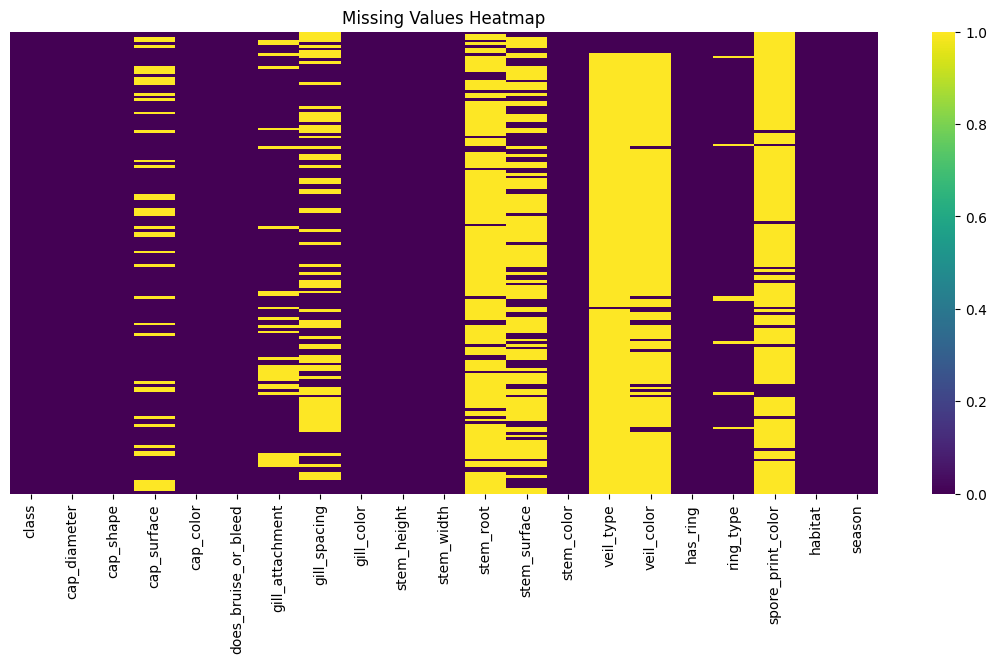

class                       0
cap_diameter                0
cap_shape                   0
cap_surface             14120
cap_color                   0
does_bruise_or_bleed        0
gill_attachment          9884
gill_spacing            25063
gill_color                  0
stem_height                 0
stem_width                  0
stem_root               51538
stem_surface            38124
stem_color                  0
veil_type               57892
veil_color              53656
has_ring                    0
ring_type                2471
spore_print_color       54715
habitat                     0
season                      0
dtype: int64

In [3]:
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

df.isnull().sum()

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


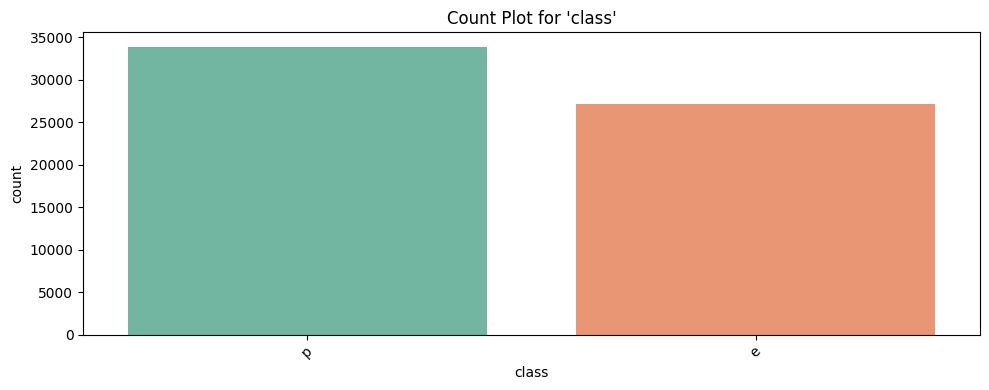

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


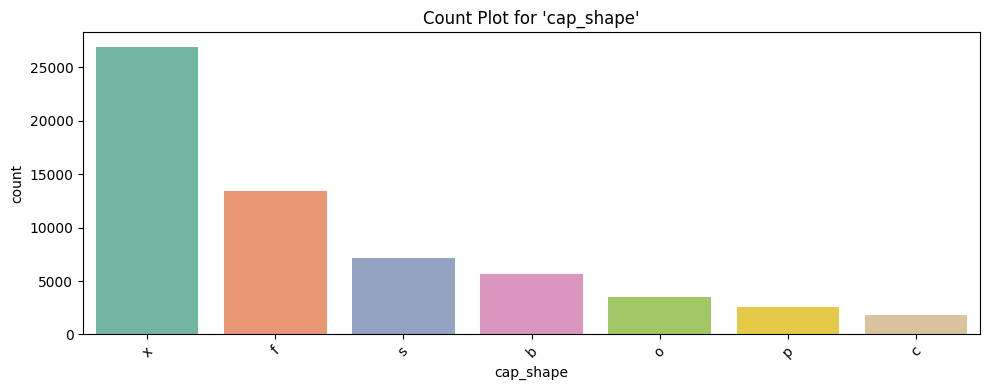

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


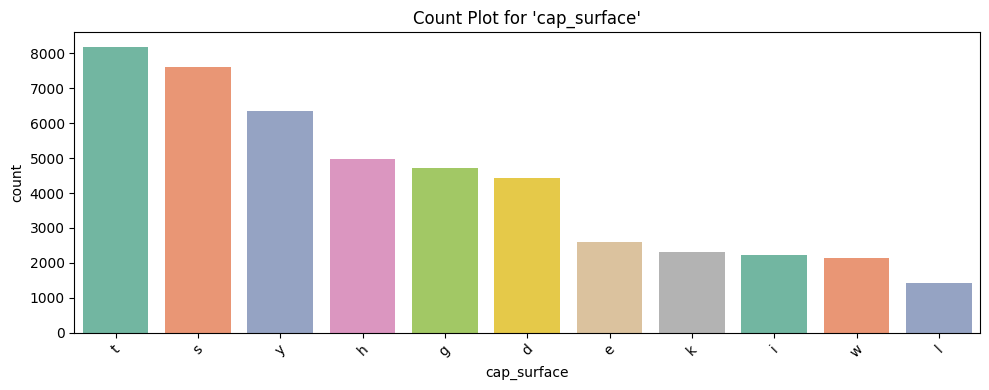

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


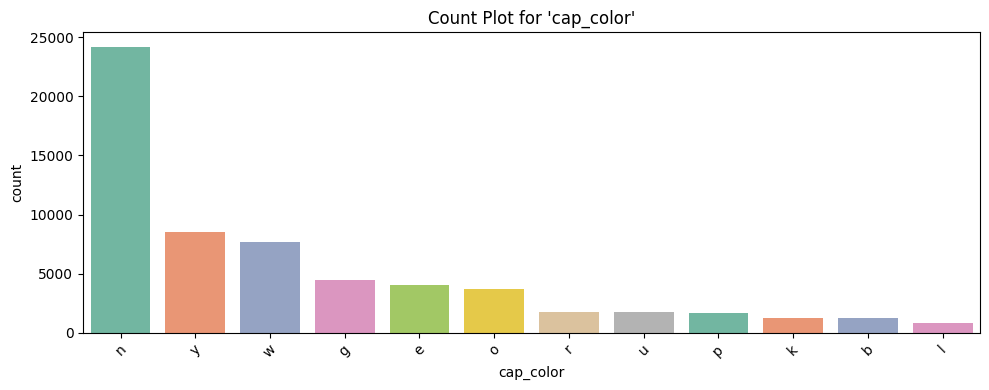

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


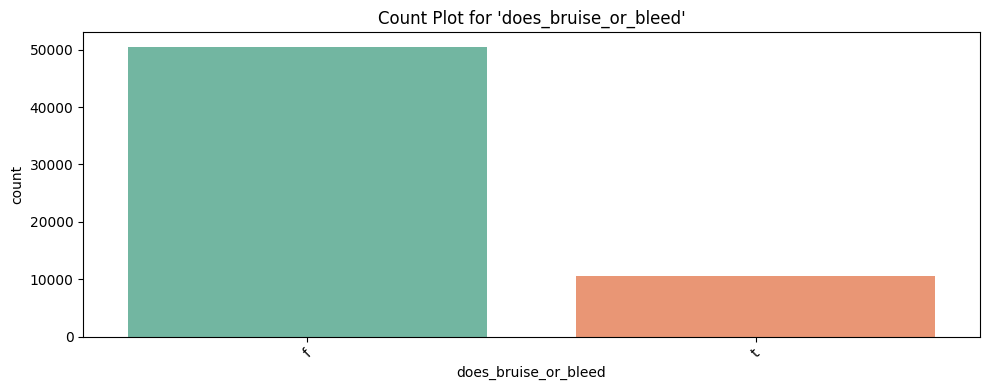

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


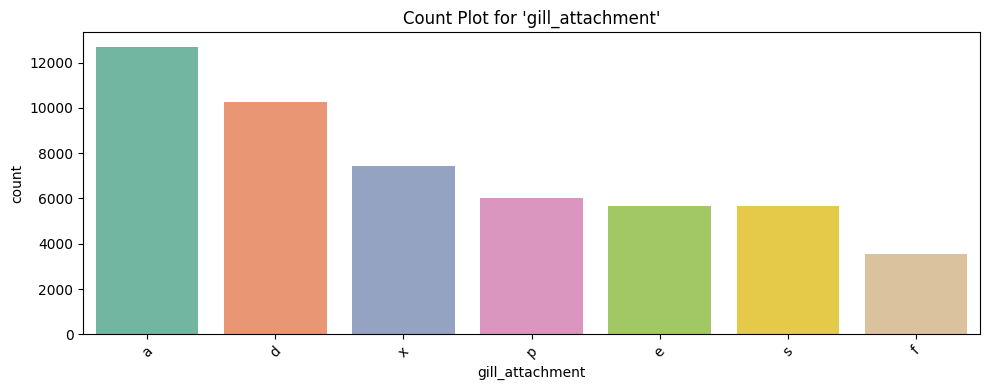

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


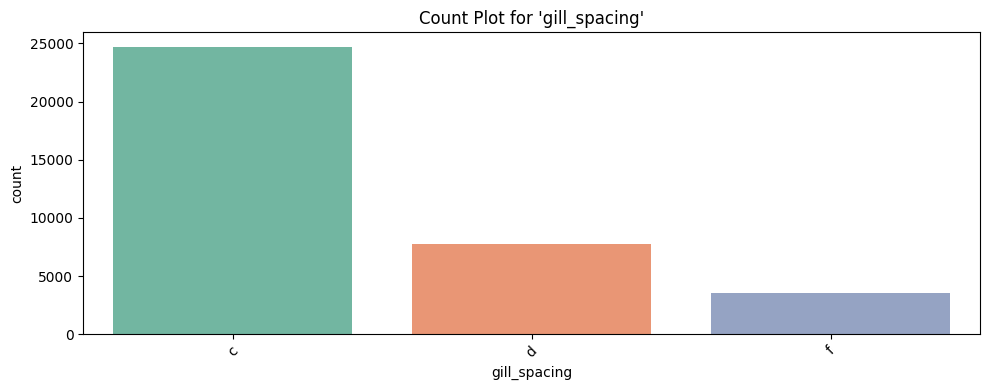

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


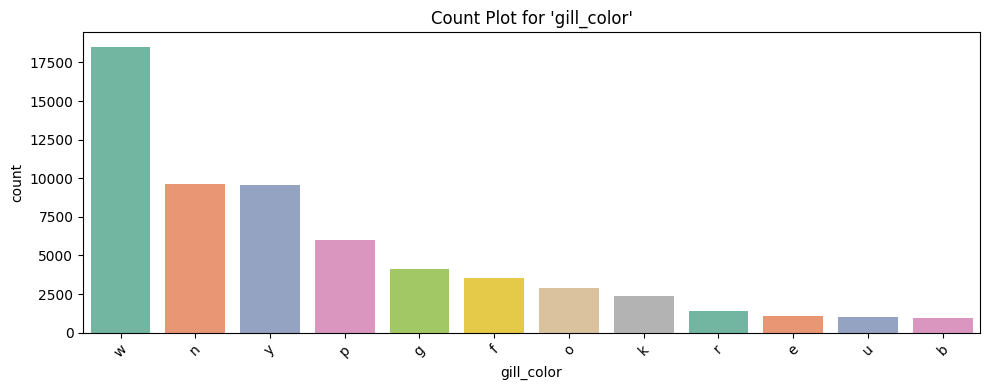

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


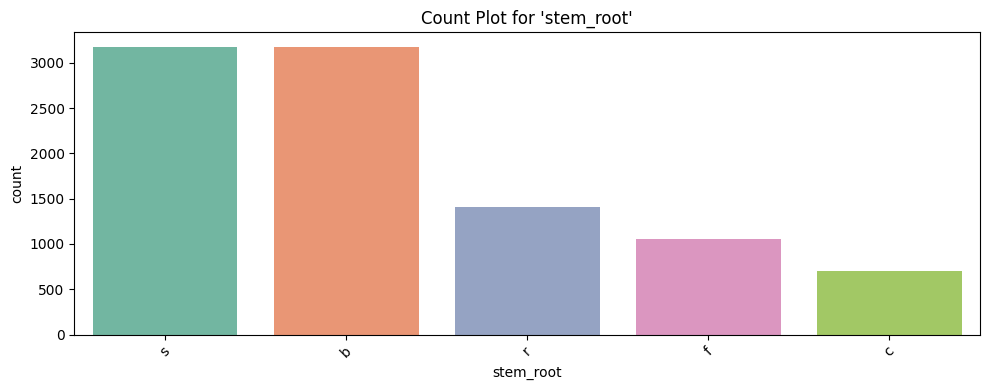

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


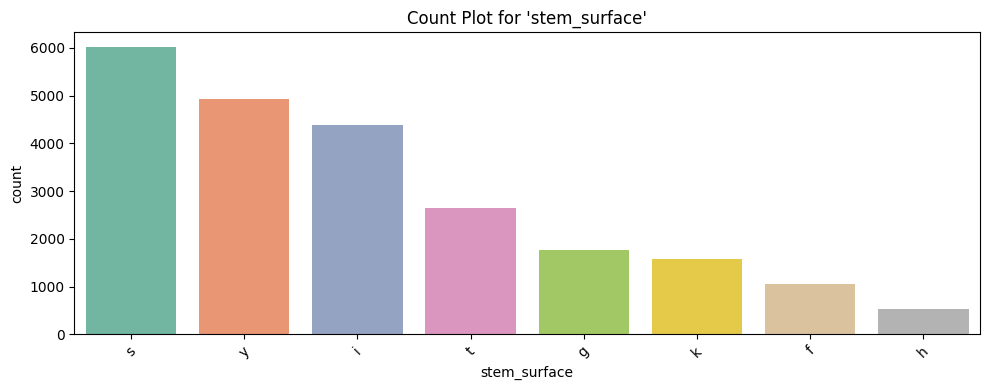

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


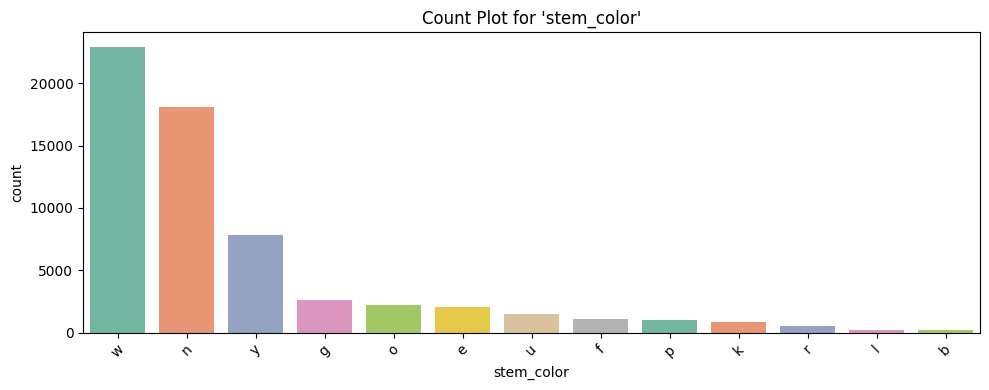

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


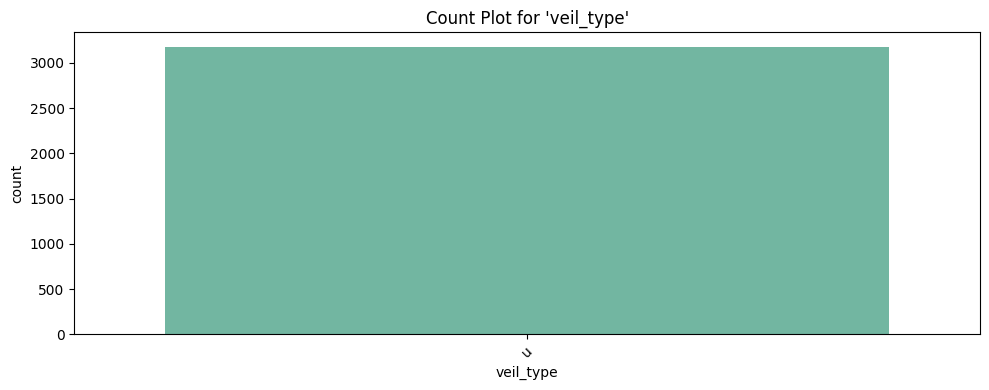

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


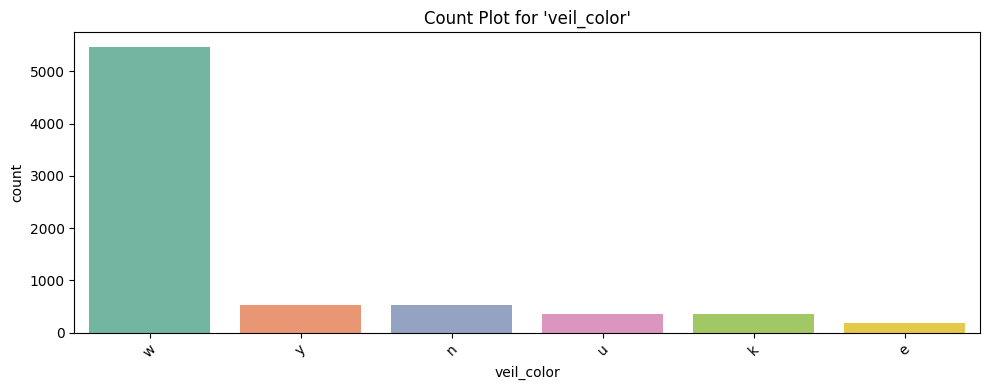

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


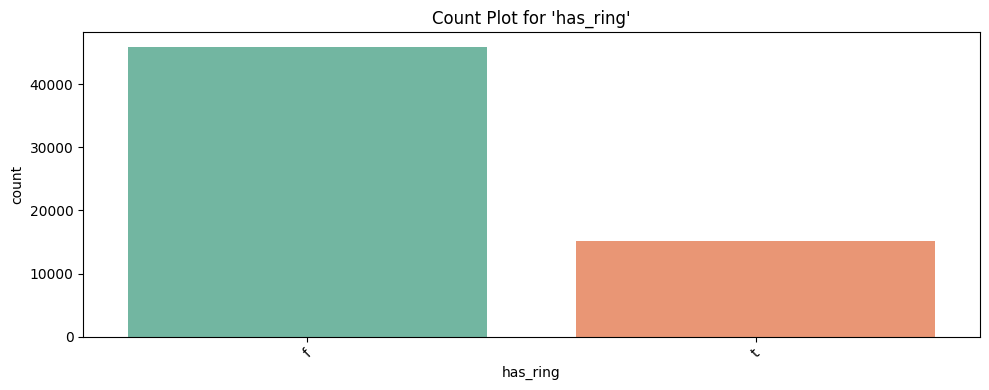

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


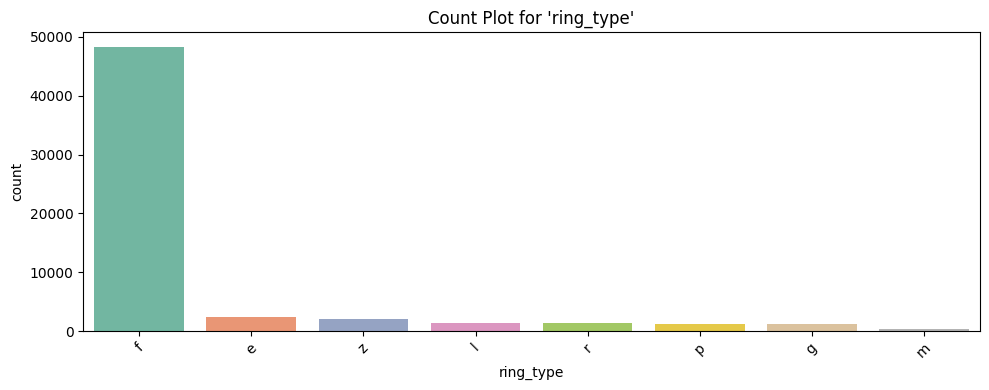

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


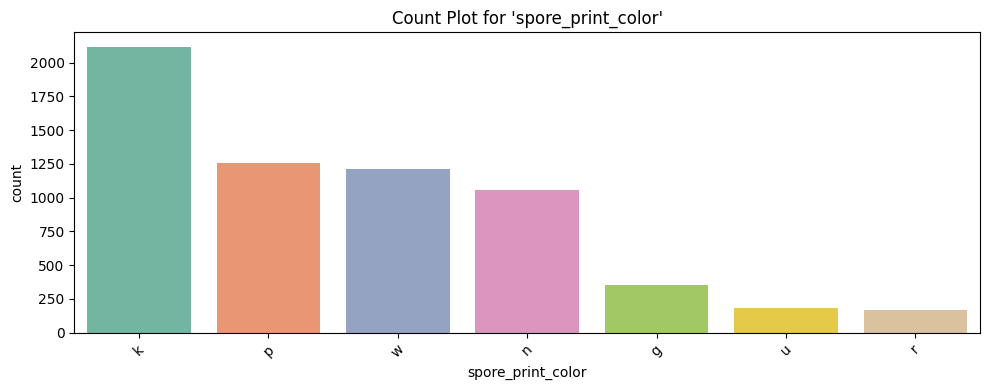

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


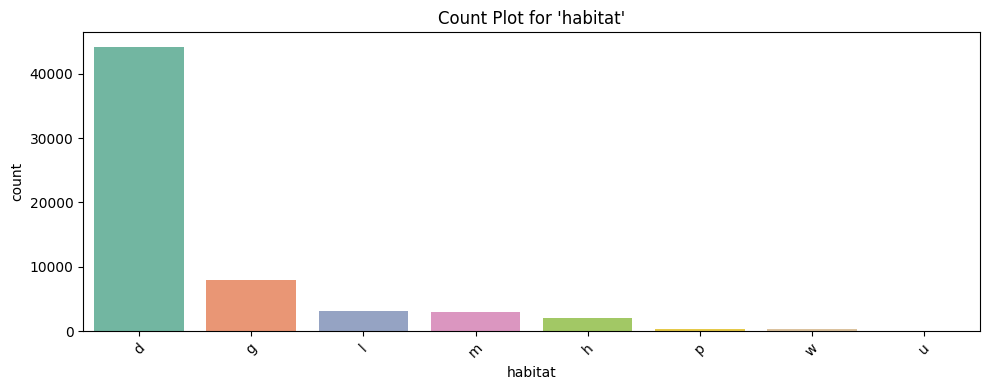

/tmp/ipykernel_13238/2442641433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


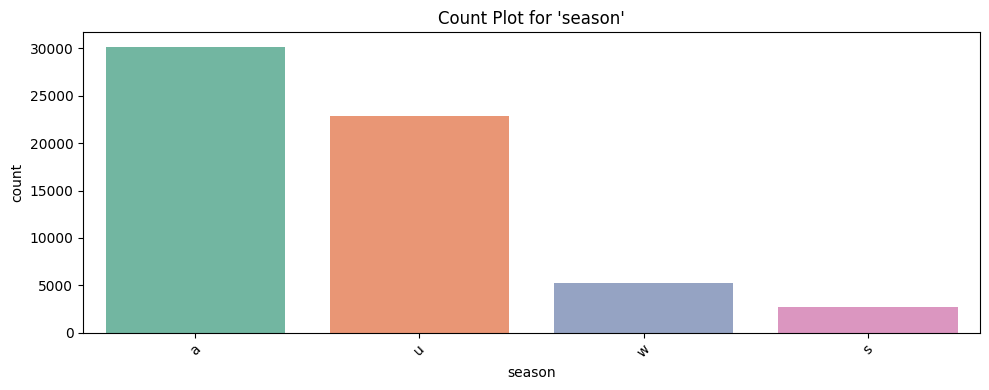

In [4]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f"Count Plot for '{col}'")
    plt.tight_layout()
    plt.show()

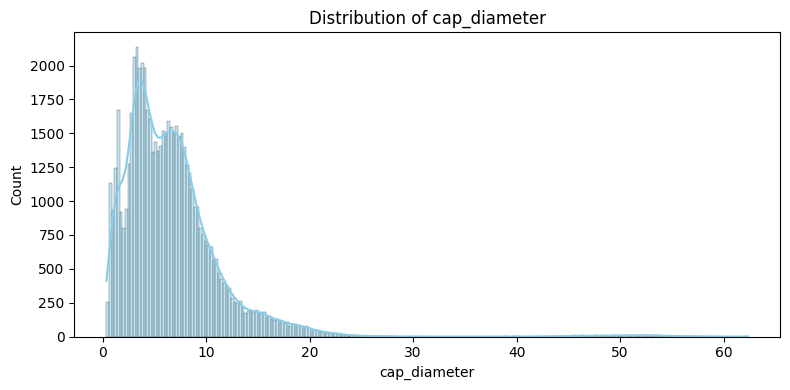

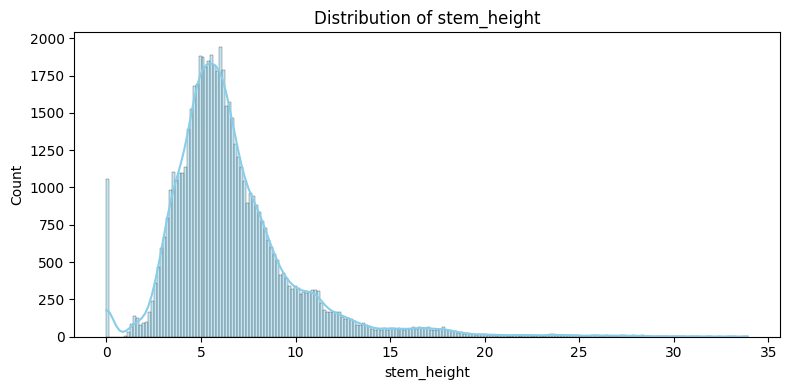

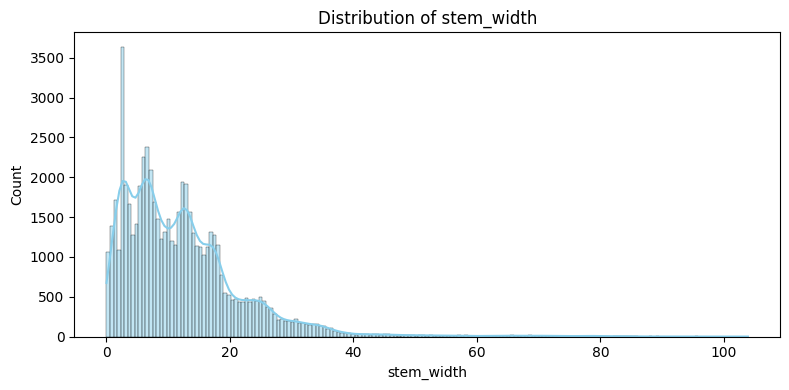

In [5]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('class_encoded', errors='ignore')
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [ ]:
# ETL Pipeline - Transform
print("🔄 Starting data transformation...")

# Log data preprocessing with MLflow
with mlflow.start_run(run_name="data_preprocessing"):
    # Log original data shape
    mlflow.log_metric("original_rows", df.shape[0])
    mlflow.log_metric("original_columns", df.shape[1])
    
    # Drop columns with too many missing values
    columns_to_drop = ['gill_spacing', 'stem_surface', 'stem_root', 'spore_print_color', 'veil_type', 'veil_color']
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    if existing_columns:
        df.drop(columns=existing_columns, inplace=True)
        mlflow.log_param("dropped_columns", existing_columns)

    label_encoder = LabelEncoder()

    def encode_and_impute(column):
        encoded = label_encoder.fit_transform(df[column].astype(str))
        encoded = pd.Series(encoded)
        encoded[encoded == label_encoder.transform(['nan'])[0]] = np.nan
        
        # Get values to sample from non-NaN entries
        non_nan_values = encoded.dropna().values
        
        # Sample randomly from these values
        if encoded.isna().sum() > 0 and len(non_nan_values) > 0:
            sampled_values = np.random.choice(non_nan_values, size=encoded.isna().sum(), replace=True)
            # Create a copy and set the NaN values to the sampled values
            filled = encoded.copy()
            filled[filled.isna()] = sampled_values
        else:
            filled = encoded.copy()
            
        return label_encoder.inverse_transform(filled.astype(int))

    # Check if these columns exist before trying to encode them
    encoded_columns = []
    if 'cap_surface' in df.columns:
        df['cap_surface'] = encode_and_impute('cap_surface')
        encoded_columns.append('cap_surface')
    if 'gill_attachment' in df.columns:
        df['gill_attachment'] = encode_and_impute('gill_attachment')
        encoded_columns.append('gill_attachment')
    if 'ring_type' in df.columns:
        df['ring_type'] = encode_and_impute('ring_type')
        encoded_columns.append('ring_type')
    
    mlflow.log_param("encoded_columns", encoded_columns)

    # Encode target and boolean columns
    df['class_encoded'] = label_encoder.fit_transform(df['class'])
    df['does_bruise_or_bleed_encoded'] = label_encoder.fit_transform(df['does_bruise_or_bleed'])
    df['has_ring_encoded'] = label_encoder.fit_transform(df['has_ring'])

    # Handle rare categories
    possible_columns = ['habitat', 'stem_color', 'gill_color', 'cap_color', 'cap_shape', 'cap_surface', 'ring_type']
    rare_category_mapping = {}
    for col in [col for col in possible_columns if col in df.columns]:
        rare_vals = df[col].value_counts()[df[col].value_counts() < 1000].index
        if len(rare_vals) > 0:
            rare_category_mapping[col] = list(rare_vals)
            df[col] = df[col].replace(rare_vals, 'Other')
    
    mlflow.log_param("rare_category_mapping", rare_category_mapping)

    # Drop original categorical columns
    df.drop(columns=['class', 'does_bruise_or_bleed', 'has_ring'], inplace=True)
    
    # Log processed data shape
    mlflow.log_metric("processed_rows", df.shape[0])
    mlflow.log_metric("processed_columns", df.shape[1])
    mlflow.log_metric("missing_values_after_processing", df.isnull().sum().sum())
    
    # Save processed data
    processed_data_path = "data/processed/notebook_processed_data.csv"
    os.makedirs("data/processed", exist_ok=True)
    df.to_csv(processed_data_path, index=False)
    mlflow.log_artifact(processed_data_path)
    
    print(f"✅ Data preprocessing completed. Final shape: {df.shape}")

# Validate processed data
validation_results = validate_data_quality(df, "processed_data_validation")
print(f"🔍 Processed data validation: {validation_results['summary']}")

Data preprocessing completed. Final shape: (61069, 15)
🏃 View run data_preprocessing at: http://localhost:5000/#/experiments/1/runs/c652da0f58d845968ecd6933d575b2f1
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [7]:
for col in ['cap_diameter', 'stem_height', 'stem_width']:
    df = df[(zscore(df[col]) < 2.5)]
df.reset_index(drop=True, inplace=True)

In [8]:
# ETL Pipeline - Load (prepare for modeling)
df = pd.get_dummies(df, drop_first=True)
X = df.drop(columns=['class_encoded'])
y = df['class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature columns: {X.columns.tolist()}")

Training set shape: (40131, 73)
Test set shape: (17199, 73)
Feature columns: ['cap_diameter', 'stem_height', 'stem_width', 'does_bruise_or_bleed_encoded', 'has_ring_encoded', 'cap_shape_c', 'cap_shape_f', 'cap_shape_o', 'cap_shape_p', 'cap_shape_s', 'cap_shape_x', 'cap_surface_e', 'cap_surface_g', 'cap_surface_h', 'cap_surface_i', 'cap_surface_k', 'cap_surface_l', 'cap_surface_s', 'cap_surface_t', 'cap_surface_w', 'cap_surface_y', 'cap_color_b', 'cap_color_e', 'cap_color_g', 'cap_color_k', 'cap_color_n', 'cap_color_o', 'cap_color_p', 'cap_color_r', 'cap_color_u', 'cap_color_w', 'cap_color_y', 'gill_attachment_d', 'gill_attachment_e', 'gill_attachment_f', 'gill_attachment_p', 'gill_attachment_s', 'gill_attachment_x', 'gill_color_e', 'gill_color_f', 'gill_color_g', 'gill_color_k', 'gill_color_n', 'gill_color_o', 'gill_color_p', 'gill_color_r', 'gill_color_u', 'gill_color_w', 'gill_color_y', 'stem_color_e', 'stem_color_f', 'stem_color_g', 'stem_color_n', 'stem_color_o', 'stem_color_p', 's

In [ ]:
# Enhanced Model Training with MLflow Tracking and Monitoring
print("🤖 Starting enhanced model training with MLflow tracking...")

models = {
    'logistic_regression': LogisticRegression(max_iter=200, random_state=42),
    'decision_tree': DecisionTreeClassifier(max_depth=12, random_state=42),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'xgboost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

model_results = {}

# Set parent run for model training
with mlflow.start_run(run_name="notebook_model_training_pipeline") as parent_run:
    mlflow.log_param("total_models", len(models))
    mlflow.log_param("training_data_shape", X_train.shape)
    mlflow.log_param("test_data_shape", X_test.shape)
    
    for model_name, model in models.items():
        print(f"\n🔄 Training {model_name}...")
        
        with mlflow.start_run(run_name=f"notebook_{model_name}", nested=True):
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Calculate comprehensive metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            
            # Log metrics
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("mcc", mcc)
            
            if y_pred_proba is not None:
                auc = roc_auc_score(y_test, y_pred_proba)
                mlflow.log_metric("auc", auc)
            
            # Log model parameters
            if hasattr(model, 'get_params'):
                for param, value in model.get_params().items():
                    mlflow.log_param(param, value)
            
            # Log training data info
            mlflow.log_metric("training_samples", len(X_train))
            mlflow.log_metric("test_samples", len(X_test))
            mlflow.log_metric("feature_count", X_train.shape[1])
            
            # Create and log confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Poisonous', 'Edible'],
                       yticklabels=['Poisonous', 'Edible'])
            plt.title(f'Confusion Matrix - {model_name}')
            plt.tight_layout()
            
            # Save and log confusion matrix
            cm_path = f"plots/notebook_cm_{model_name}.png"
            os.makedirs("plots", exist_ok=True)
            plt.savefig(cm_path)
            mlflow.log_artifact(cm_path)
            plt.close()
            
            # Save model
            mlflow.sklearn.log_model(
                model, 
                model_name,
                signature=mlflow.models.infer_signature(X_train, y_pred)
            )
            
            # Store results
            model_results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
                'auc': auc if y_pred_proba is not None else None
            }
            
            print(f"✅ {model_name} trained - Accuracy: {accuracy:.4f}")
    
    # Log best model info
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_accuracy = model_results[best_model_name]['accuracy']
    
    mlflow.log_param("best_model", best_model_name)
    mlflow.log_metric("best_accuracy", best_accuracy)
    
    print(f"\n🏆 Best model: {best_model_name} with accuracy: {best_accuracy:.4f}")
    print("✅ All models trained with comprehensive MLflow tracking")

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/05/24 20:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/24 20:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic_regression trained - Accuracy: 0.7730
🏃 View run notebook_logistic_regression at: http://localhost:5000/#/experiments/1/runs/2ac4123bad8140ccb080d315dd067e18
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/05/24 20:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


decision_tree trained - Accuracy: 0.9459
🏃 View run notebook_decision_tree at: http://localhost:5000/#/experiments/1/runs/70f4d47d4cdb430b935a2a11b8223b0c
🧪 View experiment at: http://localhost:5000/#/experiments/1


/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/05/24 20:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/24 20:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgboost trained - Accuracy: 0.9981
🏃 View run notebook_xgboost at: http://localhost:5000/#/experiments/1/runs/50b0473ac97243fab6fd37a5bc88c4a3
🧪 View experiment at: http://localhost:5000/#/experiments/1
All models trained with MLflow tracking


In [10]:
# Legacy training code (kept for reference)
# lr = LogisticRegression(max_iter=200)
# lr.fit(X_train, y_train)

# dt = DecisionTreeClassifier(max_depth=12)
# dt.fit(X_train, y_train)

# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# xgb_model.fit(X_train, y_train)

# Use models from the MLflow tracked training above
lr = model_results['logistic_regression']['model']
dt = model_results['decision_tree']['model'] 
xgb_model = model_results['xgboost']['model']

In [10]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n--- {name} ---")
    print("Accuracy (Test):", accuracy_score(y_test, y_pred_test))
    print("Precision (Test):", precision_score(y_test, y_pred_test))
    print("Recall (Test):", recall_score(y_test, y_pred_test))
    print("F1 Score (Test):", f1_score(y_test, y_pred_test))
    print("MCC (Test):", matthews_corrcoef(y_test, y_pred_test))

evaluate_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)
evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)


--- Logistic Regression ---
Accuracy (Test): 0.773882202453631
Precision (Test): 0.8075392670157068
Recall (Test): 0.7899211307999591
F1 Score (Test): 0.798633045099156
MCC (Test): 0.5410698495145284

--- Decision Tree ---
Accuracy (Test): 0.9460433746148031
Precision (Test): 0.9721064443731965
Recall (Test): 0.9316808358086653
F1 Score (Test): 0.9514644351464435
MCC (Test): 0.891803736605731

--- XGBoost ---
Accuracy (Test): 0.998720855863713
Precision (Test): 0.9989755148038111
Recall (Test): 0.9987708696097511
F1 Score (Test): 0.9988731817250563
MCC (Test): 0.9973941187175019


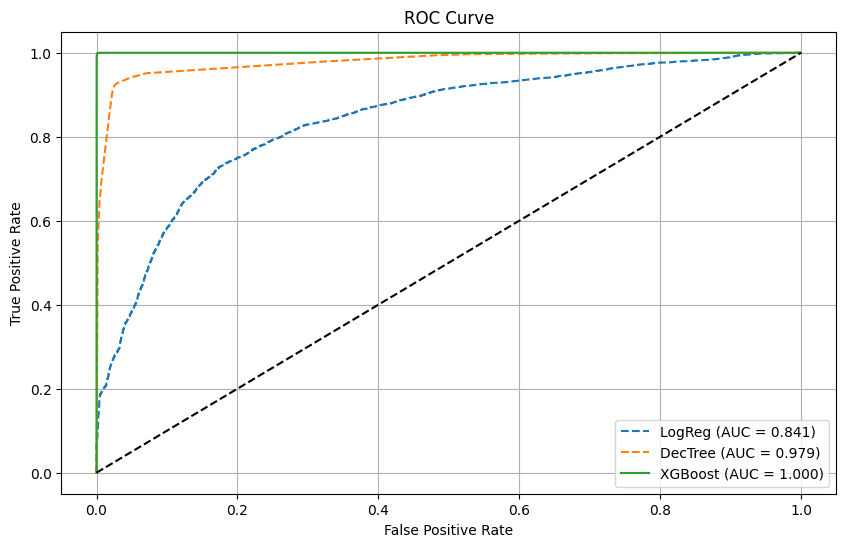

In [11]:
lr_probs = lr.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, linestyle='--', label=f'LogReg (AUC = {roc_auc_score(y_test, lr_probs):.3f})')
plt.plot(dt_fpr, dt_tpr, linestyle='--', label=f'DecTree (AUC = {roc_auc_score(y_test, dt_probs):.3f})')
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


--- Logistic Regression ---
Accuracy: 0.7730
Precision: 0.8055
Recall: 0.7910
F1 Score: 0.7982
MCC: 0.5388


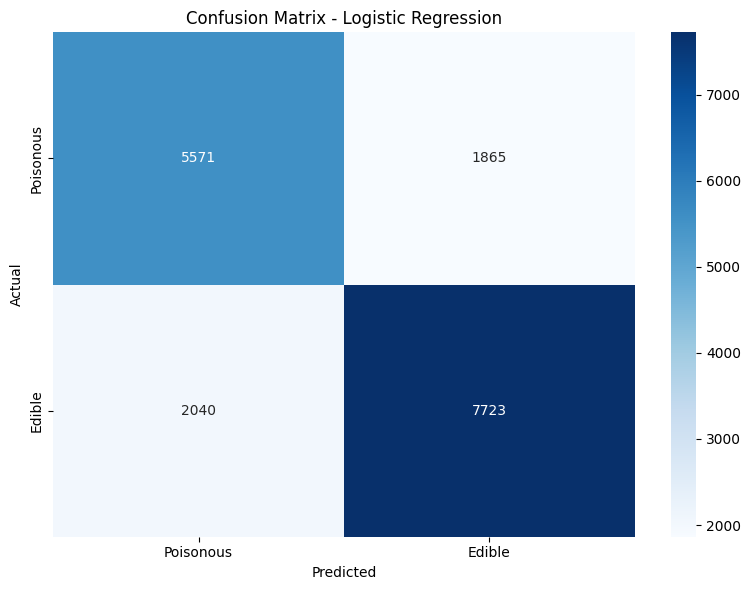

🏃 View run evaluation_Logistic Regression at: http://localhost:5000/#/experiments/1/runs/f025519c36304e5299ec0a936e5889c8
🧪 View experiment at: http://localhost:5000/#/experiments/1

--- Decision Tree ---
Accuracy: 0.9459
Precision: 0.9681
Recall: 0.9355
F1 Score: 0.9515
MCC: 0.8910


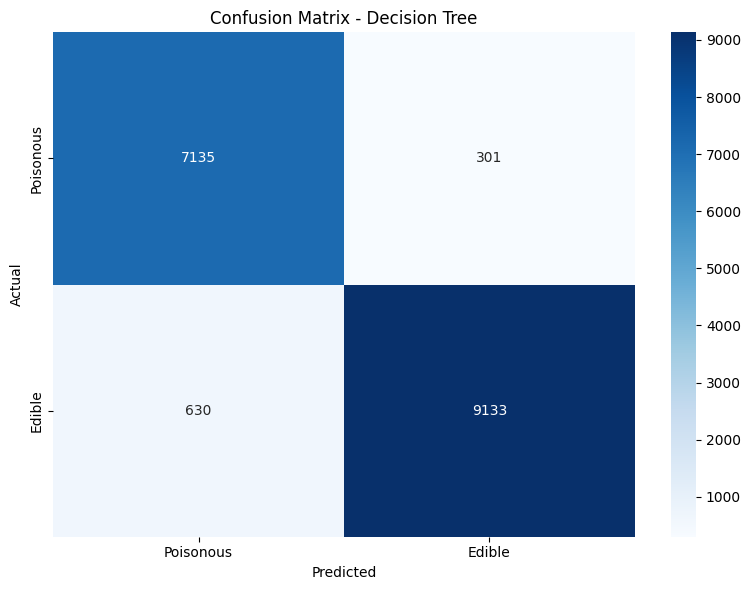

🏃 View run evaluation_Decision Tree at: http://localhost:5000/#/experiments/1/runs/0bd054a948dc44a9aba960d9d4ea2579
🧪 View experiment at: http://localhost:5000/#/experiments/1

--- XGBoost ---
Accuracy: 0.9981
Precision: 0.9982
Recall: 0.9985
F1 Score: 0.9983
MCC: 0.9961


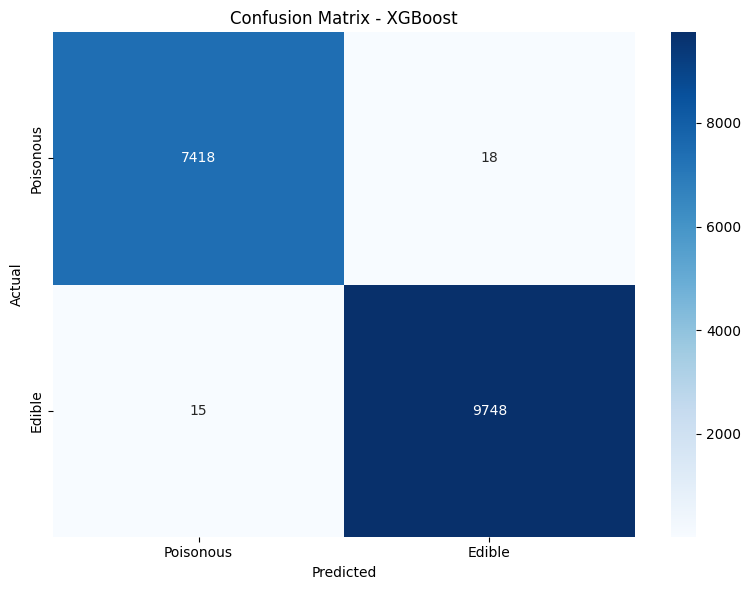

🏃 View run evaluation_XGBoost at: http://localhost:5000/#/experiments/1/runs/6e5cc9efe3dc4b2cb9ab76da319300c5
🧪 View experiment at: http://localhost:5000/#/experiments/1


<Figure size 1400x800 with 0 Axes>

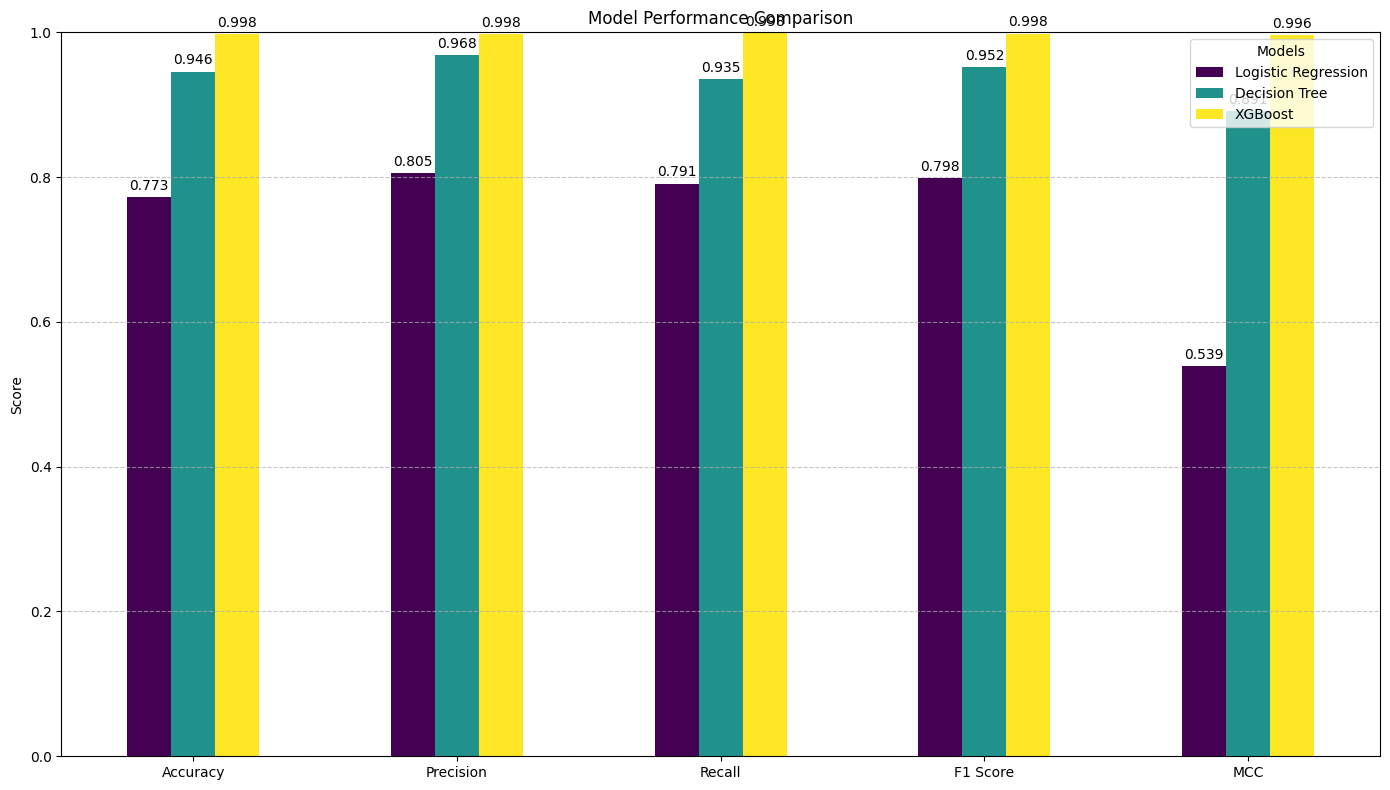

<Figure size 1200x800 with 0 Axes>

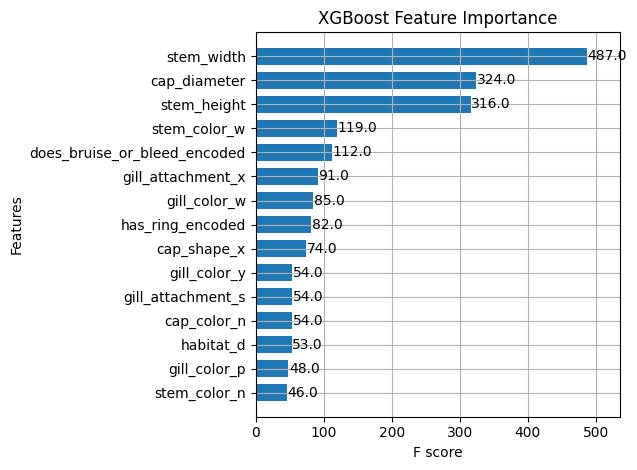

/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ankit/miniconda3/envs/mushroom

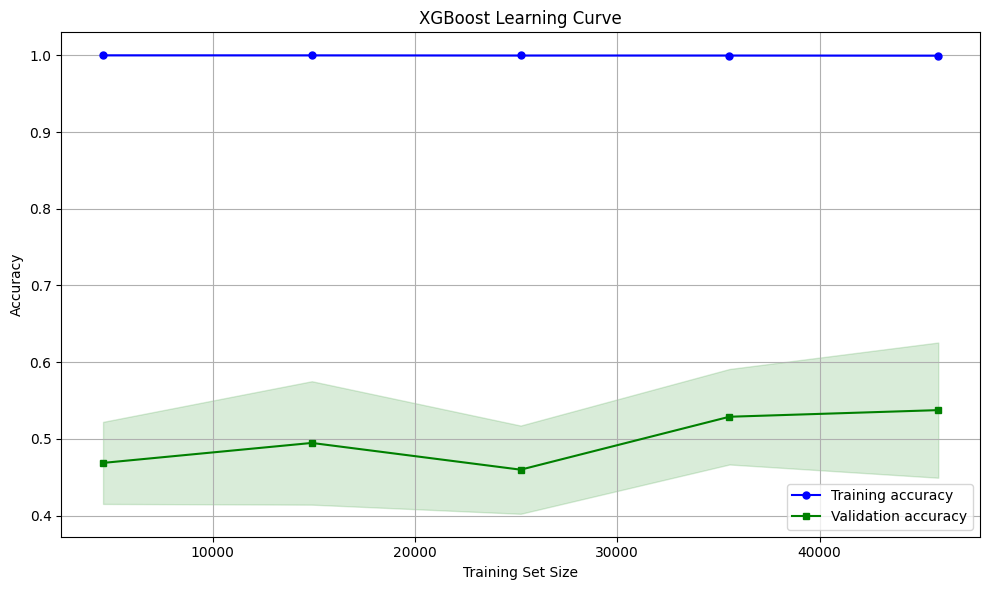

In [ ]:
# Enhanced evaluation with MLflow artifact logging and monitoring
def evaluate_model_with_comprehensive_tracking(name, model, X_train, y_train, X_test, y_test):
    """Enhanced model evaluation with comprehensive MLflow tracking"""
    
    with mlflow.start_run(run_name=f"evaluation_{name.lower().replace(' ', '_')}"):
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate comprehensive metrics
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred_test),
            'Precision': precision_score(y_test, y_pred_test),
            'Recall': recall_score(y_test, y_pred_test),
            'F1 Score': f1_score(y_test, y_pred_test),
            'MCC': matthews_corrcoef(y_test, y_pred_test),
            'Training Accuracy': accuracy_score(y_train, y_pred_train)
        }
        
        # Add AUC if available
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            metrics['AUC'] = roc_auc_score(y_test, y_pred_proba)
        
        # Log all metrics to MLflow
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name.lower().replace(' ', '_'), value)
        
        # Check for overfitting
        train_acc = metrics['Training Accuracy']
        test_acc = metrics['Accuracy']
        overfitting_gap = train_acc - test_acc
        mlflow.log_metric("overfitting_gap", overfitting_gap)
        
        if overfitting_gap > 0.1:
            mlflow.log_param("overfitting_warning", "High overfitting detected")
            print(f"⚠️ Warning: Potential overfitting detected (gap: {overfitting_gap:.3f})")
        
        print(f"\n--- {name} Comprehensive Results ---")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        
        # Create and save enhanced confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(10, 8))
        
        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Create subplot for both count and percentage
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Count matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Poisonous', 'Edible'],
                    yticklabels=['Poisonous', 'Edible'], ax=ax1)
        ax1.set_title(f'Confusion Matrix (Counts) - {name}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Percentage matrix
        sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=['Poisonous', 'Edible'],
                    yticklabels=['Poisonous', 'Edible'], ax=ax2)
        ax2.set_title(f'Confusion Matrix (%) - {name}')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        
        plt.tight_layout()
        
        # Save plot
        plot_path = f"plots/enhanced_confusion_matrix_{name.lower().replace(' ', '_')}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(plot_path)
        plt.show()
        
        # Log model summary
        model_summary = {
            "model_type": type(model).__name__,
            "feature_count": X_test.shape[1],
            "test_samples": len(y_test),
            "positive_predictions": int(y_pred_test.sum()),
            "negative_predictions": int(len(y_pred_test) - y_pred_test.sum())
        }
        
        for key, value in model_summary.items():
            mlflow.log_param(key, value)
        
        return metrics

print("🔍 Starting comprehensive model evaluation...")

# Evaluate all models with enhanced tracking
lr_metrics = evaluate_model_with_comprehensive_tracking("Logistic Regression", lr, X_train, y_train, X_test, y_test)
dt_metrics = evaluate_model_with_comprehensive_tracking("Decision Tree", dt, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model_with_comprehensive_tracking("XGBoost", xgb_model, X_train, y_train, X_test, y_test)

# Add Random Forest and Gradient Boosting if available
if 'random_forest' in model_results:
    rf_model = model_results['random_forest']['model']
    rf_metrics = evaluate_model_with_comprehensive_tracking("Random Forest", rf_model, X_train, y_train, X_test, y_test)

if 'gradient_boosting' in model_results:
    gb_model = model_results['gradient_boosting']['model']
    gb_metrics = evaluate_model_with_comprehensive_tracking("Gradient Boosting", gb_model, X_train, y_train, X_test, y_test)

print("✅ Comprehensive evaluation completed with MLflow tracking")

# Create enhanced comparative visualization
metrics_comparison = {
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'XGBoost': xgb_metrics
}

# Add other models if evaluated
if 'random_forest' in model_results:
    metrics_comparison['Random Forest'] = rf_metrics
if 'gradient_boosting' in model_results:
    metrics_comparison['Gradient Boosting'] = gb_metrics

# Create comprehensive comparison plot
metrics_df = pd.DataFrame(metrics_comparison)

plt.figure(figsize=(16, 10))
metrics_df.plot(kind='bar', figsize=(16, 10), colormap='viridis')
plt.title('Comprehensive Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f', padding=3, fontsize=8)

plt.tight_layout()

# Save comparison plot
comparison_path = "plots/comprehensive_model_comparison.png"
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
with mlflow.start_run(run_name="model_comparison_visualization"):
    mlflow.log_artifact(comparison_path)
plt.show()

In [ ]:
# Model Monitoring and Drift Detection
def monitor_model_performance_notebook(model, X_test, y_test, model_name):
    """Monitor model performance and detect potential issues"""
    
    with mlflow.start_run(run_name=f"monitoring_{model_name.lower().replace(' ', '_')}"):
        
        # Prediction distribution analysis
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Log prediction statistics
        mlflow.log_metric("positive_prediction_rate", y_pred.mean())
        mlflow.log_metric("prediction_variance", y_pred.var())
        
        if y_pred_proba is not None:
            mlflow.log_metric("avg_prediction_confidence", y_pred_proba.mean())
            mlflow.log_metric("confidence_variance", y_pred_proba.var())
            
            # Check for prediction confidence distribution
            high_confidence = (y_pred_proba > 0.8) | (y_pred_proba < 0.2)
            mlflow.log_metric("high_confidence_predictions", high_confidence.mean())
        
        # Feature importance analysis (for tree-based models)
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            # Log top features
            top_features = feature_importance.head(10)['feature'].tolist()
            mlflow.log_param("top_10_features", top_features)
            mlflow.log_metric("top_feature_importance", feature_importance.iloc[0]['importance'])
            
            # Create feature importance plot
            plt.figure(figsize=(12, 8))
            plt.barh(range(15), feature_importance.head(15)['importance'])
            plt.yticks(range(15), feature_importance.head(15)['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            
            # Save plot
            fi_path = f"plots/feature_importance_{model_name.lower().replace(' ', '_')}.png"
            plt.savefig(fi_path, dpi=300, bbox_inches='tight')
            mlflow.log_artifact(fi_path)
            plt.show()
        
        # Model calibration check
        if y_pred_proba is not None:
            from sklearn.calibration import calibration_curve
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_test, y_pred_proba, n_bins=10
            )
            
            plt.figure(figsize=(10, 6))
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
            plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
            plt.xlabel("Mean Predicted Probability")
            plt.ylabel("Fraction of Positives")
            plt.title(f"Calibration Plot - {model_name}")
            plt.legend()
            plt.grid(True)
            
            # Save calibration plot
            cal_path = f"plots/calibration_{model_name.lower().replace(' ', '_')}.png"
            plt.savefig(cal_path, dpi=300, bbox_inches='tight')
            mlflow.log_artifact(cal_path)
            plt.show()
            
            # Calculate calibration metrics
            calibration_error = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
            mlflow.log_metric("calibration_error", calibration_error)
        
        print(f"✅ Monitoring completed for {model_name}")

# Monitor all models
print("📊 Starting model monitoring and drift detection...")

monitor_model_performance_notebook(lr, X_test, y_test, "Logistic Regression")
monitor_model_performance_notebook(dt, X_test, y_test, "Decision Tree") 
monitor_model_performance_notebook(xgb_model, X_test, y_test, "XGBoost")

print("✅ Model monitoring completed for all models")

In [ ]:
# Final MLOps Pipeline Summary and Model Registry
print("📋 Generating final MLOps pipeline summary...")

with mlflow.start_run(run_name="notebook_pipeline_summary"):
    
    # Log pipeline summary metrics
    pipeline_summary = {
        "total_models_trained": len(model_results),
        "best_model": max(model_results.keys(), key=lambda k: model_results[k]['accuracy']),
        "best_accuracy": max([m['accuracy'] for m in model_results.values()]),
        "data_source": data_source,
        "final_feature_count": X.shape[1],
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "pipeline_type": "notebook_full_eda"
    }
    
    for key, value in pipeline_summary.items():
        if isinstance(value, (int, float)):
            mlflow.log_metric(key, value)
        else:
            mlflow.log_param(key, value)
    
    # Create pipeline summary visualization
    model_performance = pd.DataFrame({
        name: {
            'Accuracy': results['accuracy'],
            'F1 Score': results['f1'],
            'Precision': results['precision'],
            'Recall': results['recall']
        }
        for name, results in model_results.items()
    })
    
    plt.figure(figsize=(14, 8))
    model_performance.T.plot(kind='bar', figsize=(14, 8))
    plt.title('Final Model Performance Summary', fontsize=16)
    plt.ylabel('Score', fontsize=12)
    plt.legend(title='Metrics')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Save summary plot
    summary_path = "plots/final_pipeline_summary.png"
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(summary_path)
    plt.show()
    
    # Save model performance summary
    model_performance.to_csv("results/model_performance_summary.csv")
    mlflow.log_artifact("results/model_performance_summary.csv")
    
    print("\n" + "="*60)
    print("🎉 MUSHROOM CLASSIFICATION MLOPS PIPELINE COMPLETE")
    print("="*60)
    print(f"📊 Best Model: {pipeline_summary['best_model']}")
    print(f"🎯 Best Accuracy: {pipeline_summary['best_accuracy']:.4f}")
    print(f"📈 Models Trained: {pipeline_summary['total_models_trained']}")
    print(f"🔗 MLflow UI: http://localhost:5000")
    print(f"📁 Artifacts saved in: plots/ and results/")
    print("="*60)

print("✅ MLOps pipeline summary completed")